In [117]:
from scipy import constants
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid
import seaborn as sns
from tqdm import tqdm

In [118]:
def lennard_jones(r, epsilon=0.0103, sigma=3.4):
    """
    Calculates the Lennard_Jones potential.

    Parameters:
        r (angstrom): interatomic distance. If an array, applied to each element and preserves the shape.
        epsilon (eV): depth of the potential well (minimum energy)
        sigma (angstrom): zero potential distance

    Returns:
        Lennard_Jones potentials **(J)**
    """
    # avoid zeros
    r[r == 0] = 1e-12
    V_eV = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
    return V_eV * constants.eV

In [119]:
def distance(p1, p2):
    """
    Euclidean distance between p1 and p2.

    Parameters
    -----------------------------
    p1, p2: nd arrays of the same shape of (3, x, x, ...)

    Returns
    An nd array of euclidean distance of the shape (x, x, ...)
    """
    return np.sqrt(
        np.sum(
            (np.array(p1) - np.array(p2))**2, axis=0
        )
    )

In [129]:
def calc_integrand(x1, y1, z1, x2, y2, z2, temps):
    """
    Computes the integrand for the partition function.

    Parameters
    -------------------------------
    x1, y1, z1 (angstrom): coordinates of the first particle
    x2, y2, z2 (angstrom): coordinates of the second particle
    temps (K): a 1d array of temperatures

    Returns
    ndArray of integrands for the partition function with the same first dimension as temp.
    """

    betas = 1/(constants.k * np.array(temps))
    lj = lennard_jones(distance([x1, y1, z1], [x2, y2, z2]))
    return np.array([np.e ** (-beta_i*lj) for beta_i in tqdm(betas)])

In [131]:
def lj_partition(temps, length, n=5):
    """
    Computes the classical partition function for 2 Lennard-Jones particles
    in a cubic box with sides of length angstroms

    Parameters
    ------------------------------
    temps (K): 1d np.array of temperatures
    length (angstrom): side length of the cubic box
    n: number of points to define the integral grid

    Returns
    1d array of partition functions of the same length as temps
    """
    dim = np.linspace(0, length, n)
    print("Allocating memory...")
    x1, y1, z1, x2, y2, z2 = np.meshgrid(
        dim, dim, dim, dim, dim, dim,
        indexing='ij'
    ) # memory =  6n^6 huge!
    print("Calculating integrands...")
    integrands = calc_integrand(x1, y1, z1, x2, y2, z2, temps)
    results = np.zeros(temps.shape[0])
    # 6-fold integral for each temp
    print("Integrating...")
    for i, integrand in tqdm(enumerate(integrands)):
        last_integral = integrand
        for _ in range(6):
            last_integral = trapezoid(last_integral, dim, axis=0)
        coeff = (1/constants.h)**6 # todo
        results[i] = coeff * last_integral
    return results

In [153]:
class CanonicalEnsemble:
    """
    Defines a canonical ensemble with partition function Z
    """
    def __init__(self, z, temp_1, temp_2):
        """
        CanonicalEnsemble(z)
        
        Parameters
        ---------------------------
        z: partition function at a given temperature (K). Must have signature of z(temps) where temps is a 1d np.array
        temp_1 (K): starting temperature
        temp_2 (K): ending temperature
        """
        self.z = z
        self.temp_1 = temp_1
        self.temp_2 = temp_2
        self.z_vals = None
        self.u = None
        self.cv = None
        self.thermo_df = None

    def calc_z(self, n=100):
        """
        Calculates the partition functions of the system from temp_1 to temp_2 for n points
        
        Parameters
        ----------------------------
        n: number of datapoints
        
        Returns
        -----------------------------
        An np.array of calculated partition functions from temp_1 to temp_2 with length n (J)
        """
        temps = np.linspace(self.temp_1, self.temp_2, n)
        zs = np.array(self.z(temps))
        self.z_vals = zs
        return zs
    
    def calc_u(self, n=100):
        """
        Calculates the internal energy of the system from temp_1 to temp_2 for n points
        
        Parameters
        ----------------------------
        n: number of datapoints
        
        Returns
        -----------------------------
        An np.array of calculated internal energies from temp_1 to temp_2 with length n (J)
        """
        if not self.z_vals:
            self.calc_z(n)
        temps = np.linspace(self.temp_1, self.temp_2, n)
        lnZs = np.log(self.z_vals)
        betas = 1/(constants.k*temps)
        us = -np.gradient(lnZs, betas)
        self.u = us
        return us
    
    def calc_cv(self, n=100):
        """
        Calculates the constant volume heat capacity of the system from temp_1 to temp_2 for n points
        
        Parameters
        ----------------------------
        n: number of datapoints
        
        Returns
        -----------------------------
        An np.array of calculated Cv from temp_1 to temp_2 with length n (J/K)
        """
        if not self.u:
            self.calc_u(n)
        temps = np.linspace(self.temp_1, self.temp_2, n)
        cvs = np.gradient(self.u, temps)
        self.cv = cvs
        return cvs

    def calc_thermo(self, n=100):
        """
        Calculates the internal energy, and Cv of the system from temp_1 to temp_2 for n points
        Result is stored in attributes u and cv, respectively.

        Parameters
        ----------------------------
        n: number of datapoints
        """
        self.calc_cv(n)
        self.thermo_df = pd.DataFrame({
            'temperature': np.linspace(self.temp_1, self.temp_2, n),
            'internal_energy': self.u,
            'constant_volume_heat_capacity': self.cv
        })

In [154]:
length = 10 # angstrom
n = 10

ljParticles = CanonicalEnsemble(
    lambda temps: lj_partition(temps, length=length, n=n),
    10,
    1000
)

In [155]:
ljParticles.calc_thermo(200)

Allocating memory...
Calculating integrands...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.18it/s]


Integrating...


200it [00:02, 68.51it/s]


In [135]:
ljParticles.thermo_df.to_csv("thermo_properties.csv", index=False)

In [156]:
df = ljParticles.thermo_df
max_row = df['constant_volume_heat_capacity'].idxmax(axis=0)
dissoc_temp = df.iloc[max_row]['temperature']

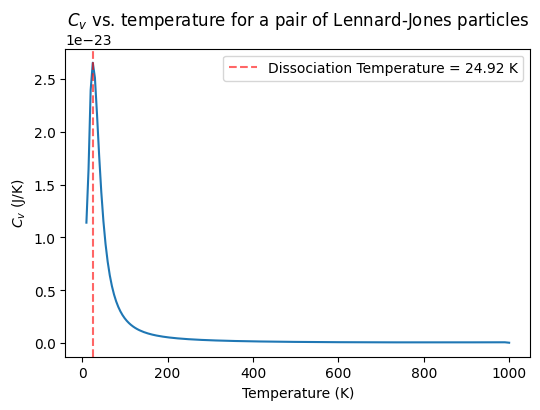

In [157]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
sns.lineplot(
    ljParticles.thermo_df,
    x = 'temperature',
    y = 'constant_volume_heat_capacity'
)
ax.axvline(x=dissoc_temp, 
           label=f'Dissociation Temperature = {dissoc_temp:.2f} K',
           linestyle='--', color='r', alpha=0.6)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('$C_v$ (J/K)')
ax.set_title("$C_v$ vs. temperature for a pair of Lennard-Jones particles")
ax.legend()
fig.savefig("cv_vs_temperature.png", dpi=210)